In [2]:
# Step 1: Clone the specific branch hackathon-prep
!git clone --branch hackathon-prep https://github.com/adamimos/epsilon-transformers.git
%cd epsilon-transformers

# Step 2: Install the necessary dependencies
!pip install -e .

# Step 3: Install gdown if not already installed
#!pip install gdown

# Step 4: Download the RRXOR experiment data
#!gdown "https://drive.google.com/uc?id=1PYMcdvvJ_FW31rQDBmnNKz9LOyFEcfqQ" -O vfs4q106-rrxor.zip

# Step 5: Unzip the data in the correct location
#!unzip vfs4q106-rrxor.zip -d examples/models/


Cloning into 'epsilon-transformers'...
remote: Enumerating objects: 5666, done.
remote: Counting objects: 100% (1049/1049), done.
remote: Compressing objects: 100% (506/506), done.
remote: Total 5666 (delta 554), reused 889 (delta 527), pack-reused 4617
Receiving objects: 100% (5666/5666), 242.68 MiB | 18.85 MiB/s, done.
Resolving deltas: 100% (3191/3191), done.
/content/epsilon-transformers
Obtaining file:///content/epsilon-transformers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from epsilon_transformers.process.processes import ZeroOneR, GoldenMean, Mess3

proc1 = ZeroOneR()
proc2 = GoldenMean(1,1)

print(proc1.transition_matrix)
print(proc2.transition_matrix)
print(proc1.vocab_len)
print(type(proc1.transition_matrix))


[[[0.  1.  0. ]
  [0.  0.  0. ]
  [0.5 0.  0. ]]

 [[0.  0.  0. ]
  [0.  0.  1. ]
  [0.5 0.  0. ]]]
[[[0.5 0. ]
  [1.  0. ]]

 [[0.  0.5]
  [0.  0. ]]]
2
<class 'numpy.ndarray'>


In [4]:
from epsilon_transformers.process.Process import Process
import numpy as np

class GluedProcess(Process):
  def __init__(self, proc1, proc2, join_on=dict(), weights=(0.5,0.5)):
        # join_on is a dictionary that maps vocubulary from Process 2 to Process 1
        # So join_on = {0: 1} means that emitting a "0" in Process 2 looks the same
        # as emitting a "1" in Process 1, but all other vocubulary of Process 1
        # is discernable.

        self.name = proc1.name + "+" + proc2.name
        self.proc1 = proc1
        self.proc2 = proc2
        self.weights = weights
        self.join_on = join_on
        super().__init__()

  def _create_hmm(self):
        n_states = len(self.proc1.state_names_dict)
        state_names = self.proc1.state_names_dict.copy()
        for key, val in self.proc2.state_names_dict.items():
          # choose a unique name for merged state in case it is already occupied
          while key in state_names:
            key += "_"
          state_names[key] = n_states
          n_states += 1

        # For a combination in which the vocabulary is disjoint, the vocab
        # size is the sum, else the larger of the two
        vocab_len = self.proc1.vocab_len + self.proc2.vocab_len - len(self.join_on)
        T = np.zeros((vocab_len, n_states, n_states))

        # Copying over values from Proc1
        shape1 = self.proc1.transition_matrix.shape
        print(shape1)
        T[:shape1[0],:shape1[1],:shape1[2]] = self.proc1.transition_matrix

        # Copying from Proc2
        new_v = 0 # This counts the number of new vocabulary tokens
        for v in range(self.proc2.vocab_len):
          if v in self.join_on:
            T[self.join_on[v],shape1[1]:, shape1[2]:] = self.proc2.transition_matrix[v,:,:]
          else:
            T[shape1[0]+new_v,shape1[1]:, shape1[2]:] = self.proc2.transition_matrix[v,:,:]
            new_v += 1

        print(T)
        return T, state_names

  @property
  def steady_state_vector(self):
      steady_state_vector = np.concatenate((self.proc1.steady_state_vector * self.weights[0], self.proc2.steady_state_vector * self.weights[1]))
      #steady_state_vector = np.ones((self.num_states))

      out = steady_state_vector / steady_state_vector.sum()
      assert out.ndim == 1
      assert len(out) == self.num_states
      return out


class BiasedCoin(Process):
    def __init__(self, bias: float = 0.5):
        self.name = "bc"
        self.p = bias
        super().__init__()

    def _create_hmm(self):
        T = np.zeros((2, 1, 1))
        state_names = {"0": 0}
        T[0, state_names["0"], state_names["0"]] = self.p
        T[1, state_names["0"], state_names["0"]] = 1-self.p

        return T, state_names


(2, 1, 1)
[[[0.5 0. ]
  [0.  0.3]]

 [[0.5 0. ]
  [0.  0. ]]

 [[0.  0. ]
  [0.  0.7]]]
(2, 1, 1)
[[[0.7 0.  0. ]
  [0.  0.5 0. ]
  [0.  0.  0.3]]

 [[0.3 0.  0. ]
  [0.  0.5 0. ]
  [0.  0.  0. ]]

 [[0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0.7]]]


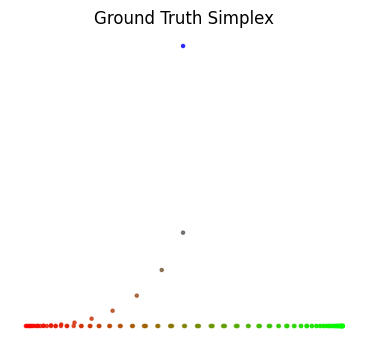

In [5]:
from epsilon_transformers.visualization.plots import _project_to_simplex
import matplotlib.pyplot as plt

proc1 = BiasedCoin(0.5)
proc2 = BiasedCoin(0.3)
proc3 = BiasedCoin(0.7)
process = GluedProcess(proc3, GluedProcess(proc1, proc2, {0:0}), {0:0,1:1}, weights=(1, 2))
mixed_state_tree = process.derive_mixed_state_presentation(depth=14)
MSP_transition_matrix = mixed_state_tree.build_msp_transition_matrix()

tree_paths, tree_beliefs = mixed_state_tree.paths_and_belief_states

msp_beliefs = [tuple(round(b, 5) for b in belief) for belief in tree_beliefs]
msp_belief_index = {b: i for i, b in enumerate(set(msp_beliefs))}
ground_truth_simplex = _project_to_simplex(np.array(list(msp_belief_index.keys())))
plt.figure(figsize=(4.5, 4))
plt.scatter(ground_truth_simplex[0], ground_truth_simplex[1], c=[k for k in list(msp_belief_index.keys())], alpha=.75, s=5)
plt.title("Ground Truth Simplex")
plt.gca().set_axis_off()
plt.show()


Transformer training


In [6]:
import torch
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache


device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
from epsilon_transformers.persistence import S3Persister, HackyPersister
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from epsilon_transformers.process.processes import RRXOR, Mess3
from epsilon_transformers.analysis.activation_analysis import get_beliefs_for_transformer_inputs
from epsilon_transformers.visualization.plots import _project_to_simplex
import seaborn as sns

import numpy as np
import torch
import plotly.express as px
import matplotlib.pyplot as plt
import pathlib

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [8]:
def get_transformer_data_from_process(process, n_ctx):
    mixed_state_tree = process.derive_mixed_state_presentation(depth=n_ctx+1)
    tree_paths, tree_beliefs = mixed_state_tree.paths_and_belief_states
    transformer_data = [x for x in tree_paths if len(x) == n_ctx+1]
    transformer_data = torch.tensor(transformer_data)
    transformer_input = transformer_data[:, :-1]
    transformer_target = transformer_data[:, 1:]
    return transformer_input, transformer_target

def get_lower_bound_for_cross_entropy(process, n_ctx):
    mixed_state_tree = process.derive_mixed_state_presentation(depth=n_ctx+1)
    myopic_entropy = mixed_state_tree.myopic_entropy
    return myopic_entropy[1:]

In [9]:
cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 3,
    d_model = 9,
    d_head = 3,
    d_mlp = 9,
    act_fn = "relu",
    normalization_type=None,
    d_vocab=3,
    n_ctx=8,
    init_weights=True,
    device=device,
    seed = 999,
)

In [10]:
import torch
from torch.utils.data import IterableDataset, DataLoader
from typing import List, Tuple, Iterable


class ProcessDataset(IterableDataset):

    def __init__(self, process, sequence_length, num_samples, fixed=False):
        super().__init__()
        self.process = process
        self.sequence_length = sequence_length
        self.num_samples = num_samples
        self.fixed = fixed
        if self.fixed:
          self.samples = list(self._get_samples())
        else:
          self.samples = None

    def _get_samples(self):
      return process.yield_emissions(
            sequence_len=self.num_samples * (self.sequence_length + 1)
        )

    def __len__(self):
        return self.num_samples

    def __iter__(self) -> Iterable[Tuple[List[int]]]:
        samples = self._get_samples() if self.samples is None else iter(self.samples)
        for _ in range(self.num_samples):
            process_history = [
                next(samples) for _ in range(self.sequence_length + 1)
            ]
            yield (process_history[:-1], process_history[1:])


def process_dataset_collate_fn(batch: List[Tuple[List[int]]]):
    data = [x[0] for x in batch]
    labels = [x[1] for x in batch]
    return torch.tensor(data, dtype=torch.long), torch.tensor(labels, dtype=torch.long)


train_dataset = ProcessDataset(process, sequence_length=cfg.n_ctx, num_samples=10000,
                                     fixed=False)
train_dataloader = DataLoader(train_dataset, batch_size=100, collate_fn=process_dataset_collate_fn)
val_dataset = ProcessDataset(process, sequence_length=cfg.n_ctx, num_samples=1000,
                                   fixed=True)
val_dataloader = DataLoader(val_dataset, batch_size=100, collate_fn=process_dataset_collate_fn)

In [11]:
proc1 = BiasedCoin(0.5)
proc2 = BiasedCoin(0.3)
proc3 = BiasedCoin(0.7)
process = GluedProcess(proc3, GluedProcess(proc1, proc2, {0:0}), {0:0,1:1}, weights=(1, 2))
transformer_inputs, transformer_targets = get_transformer_data_from_process(process, cfg.n_ctx)
minimum_loss = np.mean(get_lower_bound_for_cross_entropy(process, cfg.n_ctx))
print(f"Minimum Loss: {minimum_loss}")
transformer_inputs = transformer_inputs.to(device)
transformer_targets = transformer_targets.to(device)

(2, 1, 1)
[[[0.5 0. ]
  [0.  0.3]]

 [[0.5 0. ]
  [0.  0. ]]

 [[0.  0. ]
  [0.  0.7]]]
(2, 1, 1)
[[[0.7 0.  0. ]
  [0.  0.5 0. ]
  [0.  0.  0.3]]

 [[0.3 0.  0. ]
  [0.  0.5 0. ]
  [0.  0.  0. ]]

 [[0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0.7]]]
Minimum Loss: 0.6859985357149234


In [12]:
model = HookedTransformer(cfg)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

In [13]:
from tqdm import tqdm
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
for epoch in tqdm(range(10000)):
    train_logits = model(transformer_inputs)
    train_loss = loss_fn(train_logits.view(-1, cfg.d_vocab), transformer_targets.flatten())
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}/{10000}, Loss: {train_loss.item()/minimum_loss*100} percent of minimum, LR: {optimizer.param_groups[0]['lr']}")
        scheduler.step()

  0%|          | 5/10000 [00:00<09:26, 17.63it/s]

Epoch 1/10000, Loss: 167.16372051398648 percent of minimum, LR: 0.1


  1%|          | 103/10000 [00:03<07:14, 22.78it/s]

Epoch 101/10000, Loss: 121.71053764922473 percent of minimum, LR: 0.1


  2%|▏         | 203/10000 [00:12<11:47, 13.84it/s]

Epoch 201/10000, Loss: 112.03301650384164 percent of minimum, LR: 0.1


  3%|▎         | 302/10000 [00:18<08:15, 19.56it/s]

Epoch 301/10000, Loss: 109.27813781204902 percent of minimum, LR: 0.1


  4%|▍         | 403/10000 [00:25<12:55, 12.37it/s]

Epoch 401/10000, Loss: 108.24576752121496 percent of minimum, LR: 0.1


  5%|▌         | 503/10000 [00:30<06:33, 24.11it/s]

Epoch 501/10000, Loss: 107.87692172291845 percent of minimum, LR: 0.1


  6%|▌         | 602/10000 [00:34<06:50, 22.89it/s]

Epoch 601/10000, Loss: 107.72360886548418 percent of minimum, LR: 0.1


  7%|▋         | 703/10000 [00:42<07:24, 20.91it/s]

Epoch 701/10000, Loss: 107.64554920488972 percent of minimum, LR: 0.1


  8%|▊         | 807/10000 [00:46<03:53, 39.38it/s]

Epoch 801/10000, Loss: 107.59820424823575 percent of minimum, LR: 0.1


  9%|▉         | 908/10000 [00:48<03:47, 39.96it/s]

Epoch 901/10000, Loss: 107.56556064351028 percent of minimum, LR: 0.1


 10%|█         | 1006/10000 [00:51<05:30, 27.20it/s]

Epoch 1001/10000, Loss: 107.5625543386833 percent of minimum, LR: 0.010000000000000002


 11%|█         | 1106/10000 [00:54<03:50, 38.58it/s]

Epoch 1101/10000, Loss: 107.5598608285782 percent of minimum, LR: 0.010000000000000002


 12%|█▏        | 1206/10000 [00:57<03:39, 40.14it/s]

Epoch 1201/10000, Loss: 107.55723682841128 percent of minimum, LR: 0.010000000000000002


 13%|█▎        | 1308/10000 [00:59<03:38, 39.83it/s]

Epoch 1301/10000, Loss: 107.5547084044094 percent of minimum, LR: 0.010000000000000002


 14%|█▍        | 1405/10000 [01:02<03:32, 40.35it/s]

Epoch 1401/10000, Loss: 107.55220604663431 percent of minimum, LR: 0.010000000000000002


 15%|█▌        | 1504/10000 [01:05<05:15, 26.89it/s]

Epoch 1501/10000, Loss: 107.54978188753972 percent of minimum, LR: 0.010000000000000002


 16%|█▌        | 1607/10000 [01:08<03:32, 39.55it/s]

Epoch 1601/10000, Loss: 107.54742723838334 percent of minimum, LR: 0.010000000000000002


 17%|█▋        | 1706/10000 [01:11<03:29, 39.53it/s]

Epoch 1701/10000, Loss: 107.54514209916512 percent of minimum, LR: 0.010000000000000002


 18%|█▊        | 1804/10000 [01:13<03:22, 40.41it/s]

Epoch 1801/10000, Loss: 107.54291778114285 percent of minimum, LR: 0.010000000000000002


 19%|█▉        | 1905/10000 [01:16<03:31, 38.26it/s]

Epoch 1901/10000, Loss: 107.54072821808967 percent of minimum, LR: 0.010000000000000002


 20%|██        | 2006/10000 [01:19<05:23, 24.74it/s]

Epoch 2001/10000, Loss: 107.54050231079052 percent of minimum, LR: 0.0010000000000000002


 21%|██        | 2103/10000 [01:24<06:25, 20.51it/s]

Epoch 2101/10000, Loss: 107.54029378097594 percent of minimum, LR: 0.0010000000000000002


 22%|██▏       | 2203/10000 [01:29<07:16, 17.88it/s]

Epoch 2201/10000, Loss: 107.54006787367678 percent of minimum, LR: 0.0010000000000000002


 23%|██▎       | 2304/10000 [01:34<05:08, 24.98it/s]

Epoch 2301/10000, Loss: 107.5398593438622 percent of minimum, LR: 0.0010000000000000002


 24%|██▍       | 2407/10000 [01:37<03:08, 40.31it/s]

Epoch 2401/10000, Loss: 107.53965081404762 percent of minimum, LR: 0.0010000000000000002


 25%|██▌       | 2506/10000 [01:39<03:09, 39.57it/s]

Epoch 2501/10000, Loss: 107.53944228423302 percent of minimum, LR: 0.0010000000000000002


 26%|██▌       | 2608/10000 [01:42<03:00, 40.95it/s]

Epoch 2601/10000, Loss: 107.53923375441843 percent of minimum, LR: 0.0010000000000000002


 27%|██▋       | 2708/10000 [01:44<03:03, 39.79it/s]

Epoch 2701/10000, Loss: 107.5390078471193 percent of minimum, LR: 0.0010000000000000002


 28%|██▊       | 2805/10000 [01:48<04:46, 25.15it/s]

Epoch 2801/10000, Loss: 107.5387993173047 percent of minimum, LR: 0.0010000000000000002


 29%|██▉       | 2906/10000 [01:50<02:57, 39.87it/s]

Epoch 2901/10000, Loss: 107.53859078749014 percent of minimum, LR: 0.0010000000000000002


 30%|███       | 3006/10000 [01:53<02:52, 40.52it/s]

Epoch 3001/10000, Loss: 107.53857341000557 percent of minimum, LR: 0.00010000000000000003


 31%|███       | 3106/10000 [01:55<02:52, 40.00it/s]

Epoch 3101/10000, Loss: 107.53855603252103 percent of minimum, LR: 0.00010000000000000003


 32%|███▏      | 3199/10000 [01:58<04:04, 27.83it/s]

Epoch 3201/10000, Loss: 107.53852127755192 percent of minimum, LR: 0.00010000000000000003


 33%|███▎      | 3307/10000 [02:04<02:49, 39.47it/s]

Epoch 3301/10000, Loss: 107.53850390006738 percent of minimum, LR: 0.00010000000000000003


 34%|███▍      | 3409/10000 [02:07<02:47, 39.35it/s]

Epoch 3401/10000, Loss: 107.53848652258282 percent of minimum, LR: 0.00010000000000000003


 35%|███▌      | 3509/10000 [02:09<02:44, 39.48it/s]

Epoch 3501/10000, Loss: 107.53846914509828 percent of minimum, LR: 0.00010000000000000003


 36%|███▌      | 3608/10000 [02:12<02:40, 39.80it/s]

Epoch 3601/10000, Loss: 107.53844307887147 percent of minimum, LR: 0.00010000000000000003


 37%|███▋      | 3703/10000 [02:15<04:11, 25.00it/s]

Epoch 3701/10000, Loss: 107.53841701264464 percent of minimum, LR: 0.00010000000000000003


 38%|███▊      | 3805/10000 [02:18<02:33, 40.39it/s]

Epoch 3801/10000, Loss: 107.53839094641779 percent of minimum, LR: 0.00010000000000000003


 39%|███▉      | 3905/10000 [02:20<02:34, 39.47it/s]

Epoch 3901/10000, Loss: 107.53837356893325 percent of minimum, LR: 0.00010000000000000003


 40%|████      | 4006/10000 [02:23<02:25, 41.06it/s]

Epoch 4001/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-05


 41%|████      | 4106/10000 [02:25<02:22, 41.32it/s]

Epoch 4101/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-05


 42%|████▏     | 4204/10000 [02:29<03:49, 25.27it/s]

Epoch 4201/10000, Loss: 107.53838225767554 percent of minimum, LR: 1.0000000000000004e-05


 43%|████▎     | 4305/10000 [02:31<02:23, 39.77it/s]

Epoch 4301/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-05


 44%|████▍     | 4408/10000 [02:34<02:17, 40.55it/s]

Epoch 4401/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-05


 45%|████▌     | 4508/10000 [02:37<02:18, 39.68it/s]

Epoch 4501/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-05


 46%|████▌     | 4606/10000 [02:39<02:15, 39.95it/s]

Epoch 4601/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-05


 47%|████▋     | 4704/10000 [02:43<03:30, 25.13it/s]

Epoch 4701/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-05


 48%|████▊     | 4806/10000 [02:45<02:08, 40.34it/s]

Epoch 4801/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-05


 49%|████▉     | 4909/10000 [02:48<02:06, 40.37it/s]

Epoch 4901/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-05


 50%|█████     | 5006/10000 [02:50<02:03, 40.42it/s]

Epoch 5001/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-06


 51%|█████     | 5109/10000 [02:53<02:00, 40.63it/s]

Epoch 5101/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-06


 52%|█████▏    | 5206/10000 [02:57<03:09, 25.26it/s]

Epoch 5201/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-06


 53%|█████▎    | 5304/10000 [02:59<01:56, 40.33it/s]

Epoch 5301/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-06


 54%|█████▍    | 5408/10000 [03:03<02:47, 27.42it/s]

Epoch 5401/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-06


 55%|█████▌    | 5507/10000 [03:05<01:53, 39.67it/s]

Epoch 5501/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-06


 56%|█████▌    | 5604/10000 [03:08<02:40, 27.47it/s]

Epoch 5601/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-06


 57%|█████▋    | 5706/10000 [03:11<01:52, 38.25it/s]

Epoch 5701/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-06


 58%|█████▊    | 5808/10000 [03:14<01:45, 39.62it/s]

Epoch 5801/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-06


 59%|█████▉    | 5906/10000 [03:16<01:42, 40.03it/s]

Epoch 5901/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000004e-06


 60%|██████    | 6008/10000 [03:19<01:38, 40.46it/s]

Epoch 6001/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-07


 61%|██████    | 6104/10000 [03:22<02:31, 25.77it/s]

Epoch 6101/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-07


 62%|██████▏   | 6209/10000 [03:25<01:35, 39.62it/s]

Epoch 6201/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-07


 63%|██████▎   | 6307/10000 [03:28<01:30, 40.84it/s]

Epoch 6301/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-07


 64%|██████▍   | 6405/10000 [03:30<01:29, 40.04it/s]

Epoch 6401/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-07


 65%|██████▌   | 6504/10000 [03:33<01:26, 40.57it/s]

Epoch 6501/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-07


 66%|██████▌   | 6604/10000 [03:36<02:11, 25.91it/s]

Epoch 6601/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-07


 67%|██████▋   | 6708/10000 [03:39<01:23, 39.30it/s]

Epoch 6701/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-07


 68%|██████▊   | 6809/10000 [03:42<01:19, 40.33it/s]

Epoch 6801/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-07


 69%|██████▉   | 6908/10000 [03:44<01:16, 40.53it/s]

Epoch 6901/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-07


 70%|███████   | 7004/10000 [03:46<01:15, 39.54it/s]

Epoch 7001/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-08


 71%|███████   | 7104/10000 [03:50<01:56, 24.82it/s]

Epoch 7101/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-08


 72%|███████▏  | 7209/10000 [03:53<01:10, 39.78it/s]

Epoch 7201/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-08


 73%|███████▎  | 7306/10000 [03:55<01:07, 40.03it/s]

Epoch 7301/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-08


 74%|███████▍  | 7408/10000 [03:58<01:06, 39.06it/s]

Epoch 7401/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-08


 75%|███████▌  | 7506/10000 [04:00<01:02, 39.72it/s]

Epoch 7501/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-08


 76%|███████▌  | 7605/10000 [04:04<01:34, 25.24it/s]

Epoch 7601/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-08


 77%|███████▋  | 7707/10000 [04:07<00:58, 39.44it/s]

Epoch 7701/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-08


 78%|███████▊  | 7805/10000 [04:09<00:54, 40.17it/s]

Epoch 7801/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-08


 79%|███████▉  | 7909/10000 [04:12<00:51, 40.56it/s]

Epoch 7901/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-08


 80%|████████  | 8008/10000 [04:14<00:50, 39.18it/s]

Epoch 8001/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-09


 81%|████████  | 8103/10000 [04:18<01:16, 24.69it/s]

Epoch 8101/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-09


 82%|████████▏ | 8209/10000 [04:21<00:43, 40.86it/s]

Epoch 8201/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-09


 83%|████████▎ | 8306/10000 [04:23<00:42, 40.06it/s]

Epoch 8301/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-09


 84%|████████▍ | 8405/10000 [04:25<00:39, 40.42it/s]

Epoch 8401/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-09


 85%|████████▌ | 8506/10000 [04:28<00:36, 40.75it/s]

Epoch 8501/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-09


 86%|████████▌ | 8605/10000 [04:32<00:56, 24.73it/s]

Epoch 8601/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-09


 87%|████████▋ | 8702/10000 [04:38<01:33, 13.89it/s]

Epoch 8701/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-09


 88%|████████▊ | 8802/10000 [04:45<01:39, 12.10it/s]

Epoch 8801/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-09


 89%|████████▉ | 8903/10000 [04:51<00:36, 30.11it/s]

Epoch 8901/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000005e-09


 90%|█████████ | 9007/10000 [04:54<00:24, 40.08it/s]

Epoch 9001/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000006e-10


 91%|█████████ | 9106/10000 [04:57<00:25, 34.99it/s]

Epoch 9101/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000006e-10


 92%|█████████▏| 9206/10000 [05:00<00:23, 33.47it/s]

Epoch 9201/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000006e-10


 93%|█████████▎| 9306/10000 [05:03<00:18, 38.11it/s]

Epoch 9301/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000006e-10


 94%|█████████▍| 9407/10000 [05:06<00:15, 38.22it/s]

Epoch 9401/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000006e-10


 95%|█████████▌| 9505/10000 [05:08<00:16, 30.30it/s]

Epoch 9501/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000006e-10


 96%|█████████▌| 9605/10000 [05:12<00:16, 24.37it/s]

Epoch 9601/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000006e-10


 97%|█████████▋| 9708/10000 [05:16<00:07, 38.87it/s]

Epoch 9701/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000006e-10


 98%|█████████▊| 9805/10000 [05:19<00:05, 38.60it/s]

Epoch 9801/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000006e-10


 99%|█████████▉| 9906/10000 [05:21<00:02, 40.68it/s]

Epoch 9901/10000, Loss: 107.53837356893325 percent of minimum, LR: 1.0000000000000006e-10


100%|██████████| 10000/10000 [05:23<00:00, 30.87it/s]


In [14]:
import torch


# Save the entire model into current directory
torch.save(model, 'my_model.pth')



In [15]:
!ls -l


total 48
drwxr-xr-x 8 root root  4096 Jun  3 15:54 epsilon_transformers
drwxr-xr-x 2 root root  4096 Jun  3 15:53 epsilon_transformers.egg-info
drwxr-xr-x 2 root root  4096 Jun  3 15:53 examples
-rw-r--r-- 1 root root 19574 Jun  3 16:00 my_model.pth
-rw-r--r-- 1 root root   584 Jun  3 15:53 pyproject.toml
-rw-r--r-- 1 root root  2686 Jun  3 15:53 README.md
drwxr-xr-x 2 root root  4096 Jun  3 15:53 scripts
drwxr-xr-x 2 root root  4096 Jun  3 15:53 tests


In [16]:
# Load the model
loaded_model = torch.load('my_model.pth')

# Check if the model is the same model.
# By comparing the ouputs and parameters to process
input_example = torch.randint(low=0, high=proc1.vocab_len, size=(1, 8))
input_example = input_example.long()
original_output = model(input_example)
loaded_output = loaded_model(input_example)
print(torch.equal(original_output, loaded_output))


True


In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transformer_inputs = [x for x in tree_paths if len(x) == cfg.n_ctx]
transformer_inputs = torch.tensor(transformer_inputs, dtype=torch.int).to(device)

# print first few batches
print(transformer_inputs[:5])


tensor([[0, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 0, 0],
        [1, 0, 0, 1, 0, 1, 0, 1],
        [0, 2, 2, 2, 2, 2, 0, 0]], dtype=torch.int32)


In [18]:
transformer_input_beliefs, transformer_input_belief_indices = get_beliefs_for_transformer_inputs(transformer_inputs, msp_belief_index, tree_paths, tree_beliefs)
print(f"Transformer Input Beliefs: {transformer_input_beliefs.shape}, Transformer Input Belief Indices: {transformer_input_belief_indices.shape}")


Transformer Input Beliefs: torch.Size([511, 8, 3]), Transformer Input Belief Indices: torch.Size([511, 8])


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('my_model.pth')
_, activations = model.run_with_cache(transformer_inputs, names_filter=lambda x: 'resid_post' in x)
print(activations.keys())


dict_keys(['blocks.0.hook_resid_post'])


In [20]:
# we now have activations [batch, n_ctx, d_model]
# and we have transformer_input_beliefs [batch, n_ctx, belief_dim]
# and we have transformer_input_belief_indices [batch, n_ctx]

# in the end we want to do linear regression between the activations and the transformer_input_beliefs
def run_activation_to_beliefs_regression(activations, ground_truth_beliefs):

    # make sure the first two dimensions are the same
    assert activations.shape[0] == ground_truth_beliefs.shape[0]
    assert activations.shape[1] == ground_truth_beliefs.shape[1]

    # flatten the activations
    batch_size, n_ctx, d_model = activations.shape
    belief_dim = ground_truth_beliefs.shape[-1]
    activations_flattened = activations.view(-1, d_model) # [batch * n_ctx, d_model]
    ground_truth_beliefs_flattened = ground_truth_beliefs.view(-1, belief_dim) # [batch * n_ctx, belief_dim]

    # run the regression
    regression = LinearRegression()
    regression.fit(activations_flattened, ground_truth_beliefs_flattened)

    # get the belief predictions
    belief_predictions = regression.predict(activations_flattened) # [batch * n_ctx, belief_dim]
    belief_predictions = belief_predictions.reshape(batch_size, n_ctx, belief_dim)

    return regression, belief_predictions


In [21]:
acts = torch.cat([v for k, v in activations.items()], dim=-1)
regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)
print(f"Shape of belief_predictions: {belief_predictions.shape}")

Shape of belief_predictions: (511, 8, 3)


In [22]:
from epsilon_transformers.visualization import plots
print(dir(plots))


['Figure', 'Float', 'Image', 'Literal', 'RawModelConfig', 'ZeroOneR', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_project_to_simplex', 'find_msp_subspace_in_residual_stream', 'fire', 'np', 'pd', 'plt']


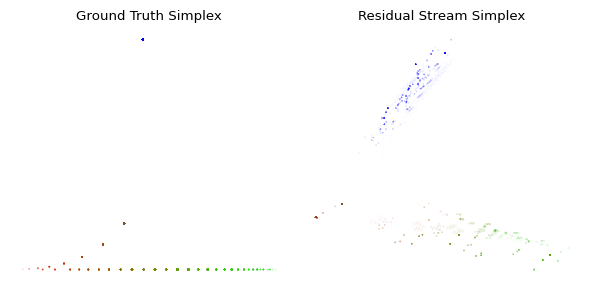

In [23]:
from epsilon_transformers.analysis.activation_analysis import find_msp_subspace_in_residual_stream
from epsilon_transformers.process.processes import Mess3


belief_predictions_flattened = belief_predictions.reshape(-1, 3)
transformer_input_belief_flattened = transformer_input_beliefs.reshape(-1, 3)

# project to simplex
belief_true_projected = _project_to_simplex(transformer_input_belief_flattened)
belief_pred_projected = _project_to_simplex(belief_predictions_flattened)

rgb_colors =  transformer_input_belief_flattened.cpu().numpy()
#rgb_colors = rgb_colors.astype(int)

sns.set_context("paper")
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Plotting the true beliefs projected onto the simplex
axes[0].scatter(belief_true_projected[0], belief_true_projected[1], marker='.', c=rgb_colors, alpha=0.2, s=0.5)
axes[0].axis('off')
axes[0].set_title("Ground Truth Simplex")

# Plotting the predicted beliefs projected onto the simplex
axes[1].scatter(belief_pred_projected[0], belief_pred_projected[1], marker='.', c=rgb_colors, alpha=0.3, s=0.01)
axes[1].axis('off')
axes[1].set_title("Residual Stream Simplex")

# Adjust layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()